<a href="https://colab.research.google.com/github/GastonRAraujo/Materia-Ap_Maq/blob/master/Proyecto_Final/CV_2df.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install swifter

#Corrección automática de examenes

En el presente trabajo se utilizará un dataset que consta de ocho grupos de "ensayos" con una extensión promedio de 150 a 550 palabras. El objetivo es aprender a utilizar texto como variable de entrada, el cual requiere una etapa de preprocesado diferente al utilizar otro tipo de variables (numéricas, categoricas, etc...). Esto se llevará a cabo implementando diferentes modelos de clasificación que permitan asignar una calificacion a cada "ensayo".

##Dataset

## Cargar dataset

Para cargar el dataset, utilizo la API de Kaggle. La cual requiere utilizar un archivo ".json" que permite descargar el dataset. Luego subí los archivos al repostiorio del proyecto para evitar repetir este proceso (subir .json y descargar todo el dataset) cada vez que utilice colab. 
Para descargar los datos cree el notebook [DownloadData_wAPI](https://github.com/GastonRAraujo/Materia-Ap_Maq/blob/master/Proyecto_Final/DownloadData_wAPI.ipynb), donde se encuentra el procedimiento paso a paso para descargar los archivos y subirlos a GitHub.

Una vez realizado esto, podemos acceder a ellos utilizando el link que nos otorga GitHub

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 4)

df_train = pd.read_csv('https://raw.githubusercontent.com/GastonRAraujo/Materia-Ap_Maq/master/Proyecto_Final/training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1')
df_test = pd.read_csv('https://raw.githubusercontent.com/GastonRAraujo/Materia-Ap_Maq/master/Proyecto_Final/valid_set.csv', sep=',', encoding='ISO-8859-1')

In [ ]:
df_train.head(3)

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_test.head(3)

,essay_id,essay_set,essay,predicted_score
0,1788,1,"Dear @ORGANIZATION1, @CAPS1 more and more peop...",7
1,1789,1,Dear @LOCATION1 Time @CAPS1 me tell you what I...,8
2,1790,1,"Dear Local newspaper, Have you been spending a...",9


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        12976 non-null  int64  
 1   essay_set       12976 non-null  int64  
 2   essay           12976 non-null  object 
 3   rater1_domain1  12976 non-null  int64  
 4   rater2_domain1  12976 non-null  int64  
 5   rater3_domain1  128 non-null    float64
 6   domain1_score   12976 non-null  int64  
 7   rater1_domain2  1800 non-null   float64
 8   rater2_domain2  1800 non-null   float64
 9   domain2_score   1800 non-null   float64
 10  rater1_trait1   2292 non-null   float64
 11  rater1_trait2   2292 non-null   float64
 12  rater1_trait3   2292 non-null   float64
 13  rater1_trait4   2292 non-null   float64
 14  rater1_trait5   723 non-null    float64
 15  rater1_trait6   723 non-null    float64
 16  rater2_trait1   2292 non-null   float64
 17  rater2_trait2   2292 non-null  

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4218 entries, 0 to 4217
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   essay_id         4218 non-null   int64 
 1   essay_set        4218 non-null   int64 
 2   essay            4218 non-null   object
 3   predicted_score  4218 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 131.9+ KB


In [ ]:
print(df_train.groupby('essay_set')['essay_id'].nunique().values)

print(df_test.groupby('essay_set')['essay_id'].nunique().values)

[1783 1800 1726 1770 1805 1800 1569  723]
[589 600 568 586 601 600 441 233]


En ambos casos el grupo 8 se ve subrepresentado.

Oservamos una gran presencia de valores null en algunas columnas, si investigamos sobre el dataset podemos ver el significado de cada una y poque sucede esto:


  * essay_id: un identificador único para cada ensayo individual del estudiante

  * essay_set: 1-8, una identificación para cada conjunto de ensayos

  * essay: el texto ascii de la respuesta de un estudiante

  * rater1_domain1: puntuación del dominio 1 del evaluador 1; todos los ensayos tienen esto

  * rater2_domain1: puntuación del dominio 1 del evaluador 2; todos los ensayos tienen esto

  * rater3_domain1: puntuación del dominio 1 del evaluador 3; solo algunos ensayos del conjunto 8 tienen esto.

  * domain1_score: puntuación resuelta entre los evaluadores; todos los ensayos tienen esto

  * rater1_domain2: puntuación del dominio 2 del evaluador 1; solo los ensayos del conjunto 2 tienen esto

  * rater2_domain2: puntuación del dominio 2 del evaluador 2; solo los ensayos del conjunto 2 tienen esto

  * domain2_score: puntuación resuelta entre los evaluadores; solo los ensayos del conjunto 2 tienen esto

  * rater1_trait1 score - rater3_trait6 score: puntajes de rasgos para los conjuntos 7-8


##Procesamiento de datos

En esta sección procesaremos los datos por lo que analizaremos como reducir la dimension de nuestro dataset, como tratar los valores NaN y por último realizaremos el procesamiento de texto.


###Procesamiento de variables númericas

Analicemos la distribucion de notas de cada grupo

In [ ]:
import plotly.express as px

fig = px.histogram(df_train, x="domain1_score", color="essay_set", marginal="rug", hover_data=None)
fig.show()

Los grupos poseen diferentes distribuciones de notas. Mientras la mayoría se encuentra con una media menor a 30 puntos, el grupo 8 posee una distribución con notas más altas.
A su vez se observa que una gran cantidad de alumnos a obtenido una calificación menor a 6.

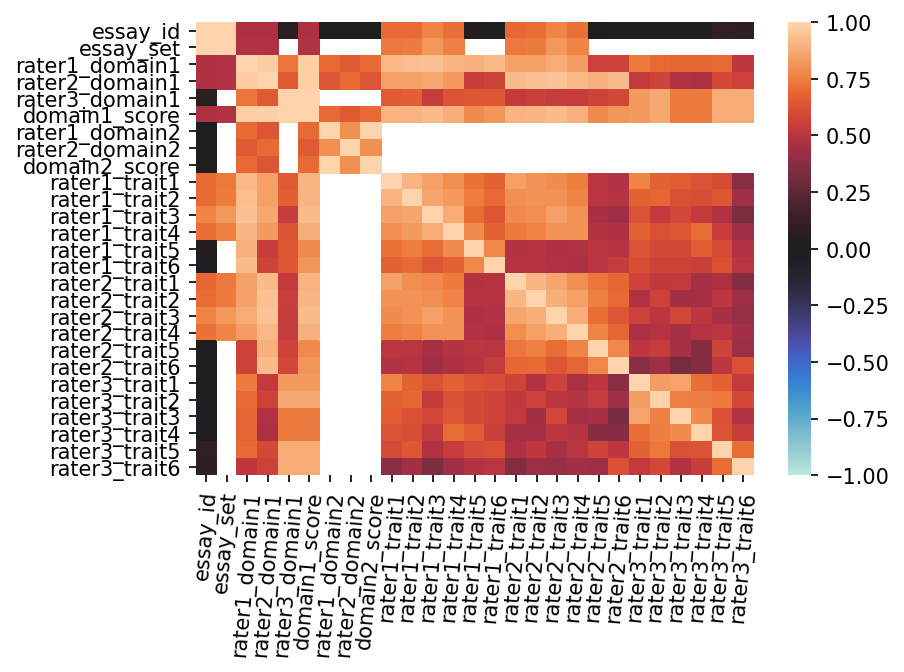

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Correlation matrix
plt.figure(dpi=150)
 
sns.heatmap(df_train.corr(), vmin=-1, vmax=1, center= 0, xticklabels=True, yticklabels=True)
 
#Adjust font size
sns.set(font_scale=0.7)
 
# Rotate the tick labels a bit
plt.xticks(rotation=85)
 
plt.show()

Se observa una correlación entre algunas columnas, lo cual surge de que las columnas "rater#_trait#" contienen la información con la que cada evualdor calificó finalmente al alumno. Por lo que un alumno que obtenga altos puntajes en los diferentes rasgos, obtendrá un puntaje alto según ese evaluador. A su vez vemos que estos rasgos estan fuertemente relacionados entre si.
En principio pareciera que "domain1_score" es simplemente la suma de las calificaciones. Comprobemos que "domain1_score" NO es la suma de las calificaciones que le han otorgado.

In [ ]:
dummy_df = df_train[df_train['domain1_score']!=df_train['rater1_domain1']+df_train['rater2_domain1']]

dummy_df

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
1783,2978,2,Certain materials being removed from libraries...,4,4,NaN,4,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1784,2979,2,Write a persuasive essay to a newspaper reflec...,1,2,NaN,1,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12970,21624,8,"Sometime ago on a hot @DATE1 day my @NUM1 ,@PE...",17,15,30.0,30,NaN,NaN,NaN,3.0,3.0,4.0,4.0,5.0,3.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,4.0,4.0,3.0,3.0
12973,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",20,26,40.0,40,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,6.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0


In [ ]:
dummy_df = df_train[df_train['rater3_domain1']!=df_train['domain1_score']]

dummy_df

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12974,21630,8,Trippin' on fen...,20,20,NaN,40,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
12975,21633,8,Many people believe that laughter can improve...,20,20,NaN,40,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


Por lo que la columna "domain1_score" no es la suma ni el promedio de las columnas "rater1_domain1",	"rater2_domain1" y	"rater3_domain1". Hay una similitud en "domain1_score" y "rater3_domain1" por lo que descartaremos esta última, además de que la amplia mayoría no cuenta con un valor para esta característica.

In [ ]:
dummy_df = df_train[df_train['rater1_trait1']>0]

dummy_df

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
10684,17834,7,Patience is when your waiting .I was patience ...,8,7,NaN,15,NaN,NaN,NaN,1.0,2.0,2.0,3.0,NaN,NaN,1.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10685,17836,7,"I am not a patience person, like I cant sit i...",6,7,NaN,13,NaN,NaN,NaN,1.0,1.0,2.0,2.0,NaN,NaN,2.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12974,21630,8,Trippin' on fen...,20,20,NaN,40,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
12975,21633,8,Many people believe that laughter can improve...,20,20,NaN,40,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


Las columnas "rater#_trait#" nos dan información de como obtuvieron el puntaje de "rater#_domain1" por lo que no las utilizaremos.

Repitamos el analisis pero para el "domain2"

In [ ]:
dummy_df = df_train[df_train['domain2_score']>0]

dummy_df

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
1783,2978,2,Certain materials being removed from libraries...,4,4,NaN,4,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1784,2979,2,Write a persuasive essay to a newspaper reflec...,1,2,NaN,1,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3581,4776,2,"I do believe that book, magazines, music, mov...",3,4,NaN,3,4.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3582,4777,2,Different Then Everyone Else @CAPS1 do peo...,3,3,NaN,3,2.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observamos que nuevamente la columna "domain1_score" no corresponde a la suma ni al promedio de las columnas de "rater#_domain2".

A continuacion eliminamos las columnas que no utilizaremos y unificaremos ambos puntajes "domain#_score" realizando un promedio de ambos.

In [ ]:
# Calculamos el promedio de puntajes ignorando NaN
# Es decir que el promedio de 5 y Nan es 5, pero 5 y 2 es (5+2)/2
df_train['score'] = df_train[['domain1_score', 'domain2_score']].mean(axis=1)


# Eliminamos las columnas que no utilizaremos:

#Eliminamos aquellas que tengan valores NaN
df_train.dropna(axis='columns',inplace=True)

#Eliminamos las restantes
df_train.drop(['rater1_domain1',	'rater2_domain1',	'domain1_score'], axis=1, inplace=True)

fig = px.histogram(df_train, x="score", color="essay_set", histnorm='probability density')
fig.show()

In [ ]:
df_train.drop(['essay_id',	'essay_set'], axis=1, inplace=True)

fig = px.histogram(df_train, x="score", histnorm='probability density')
fig.show()

Observamos la misma distribución que al comienzo solo que los grupos han sido unificados.

Para los datos de validación solo hace falta eliminar las columnas correspondientes

In [ ]:
# Eliminamos las restantes
df_test.drop(['essay_id',	'essay_set'], axis=1, inplace=True)

df_test

,essay,predicted_score
0,"Dear @ORGANIZATION1, @CAPS1 more and more peop...",7
1,Dear @LOCATION1 Time @CAPS1 me tell you what I...,8
...,...,...
4216,LAUGHTER @CAPS1 i was younger my friend live...,19
4217,"You know how the saying goes live, laugh, lov...",18


In [ ]:
fig = px.histogram(df_test, x="predicted_score", histnorm='probability density')
fig.show()

###Procesamiento de texto

Para procesar el texto y poder usarlo como input de nuestro modelo debemos realizar los siguientes pasos:

* *Tokenizar* el texto: convertir el texto en lista de palabras
* Cambiar mayúsculas por minúsculas
* Remover *stop words* (palabras que no aportan información: the, is, at, which, on, for, this, etc.) y signos de punctuación
* Stemming: método para reducir una palabra a su raíz 
* Lematización: proceso lingüístico que consiste en, dada una forma flexionada (es decir, en plural, en femenino, conjugada, etc), hallar el lema correspondiente. Por ejemplo decir es el lema de dije
* Vectorización: convertir nuestro texto tokenizado y procesado en vectores

####Tokenizacion y prepocesamiento

In [ ]:
import numpy as np
import re # expresiones regulares
import nltk #procesar texto

#descargas necesarias
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# Procesamiento de texto
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet #tipo de palabra
from nltk import word_tokenize #tokenizer

import string  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


La siguiente función elimina las signos de puntuación, convierte mayúsculas, remueve URLS, tokeniza por minúsculas y por último aplica un stemmer que reduce las palabras a su raiz. Esto puede generar que algunas palabras sean cortadas o pierdan caracteres por lo que luego se aplica un lematizador que 

In [ ]:
# Stemmer 
stemmer = nltk.stem.PorterStemmer()

# creo una lista de signos de puntuación que serán eliminados
Punct_Sign = string.punctuation

# Set de stopwords del idioma ingles
stopwords_english = set(stopwords.words('english'))

# Utilizo expresiones regulares para quitar URLs
url_pattern = re.compile(r'https?://\S+|www\.\S+')


def clean_text(text):
    # Cambiar Mayúscula por minúscula
    text = text.lower()

    # Remuevo signos de puntuación
    # maketrans(x,y,z) cambia "x" por "y" y remueve "z"
    text = text.translate(str.maketrans('', '', Punct_Sign)) #no hago cambios pero remuevo signos de puntuacion

    # Remuevo links
    text = url_pattern.sub(r'', text)

    # StopWords
    text = [stemmer.stem(word) for word in text.split() if word not in stopwords_english]

    return text

In [ ]:
df_train["text"] = df_train["essay"].apply(lambda text: clean_text(text))
df_train.head()

,essay,score,text
0,"Dear local newspaper, I think effects computer...",8.0,"[dear, local, newspap, think, effect, comput, ..."
1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0,"[dear, caps1, caps2, believ, use, comput, bene..."
...,...,...,...
3,"Dear Local Newspaper, @CAPS1 I have found that...",10.0,"[dear, local, newspap, caps1, found, mani, exp..."
4,"Dear @LOCATION1, I know having computers has a...",8.0,"[dear, location1, know, comput, posit, effect,..."


El stemmer puede suceder que elimine letras o que no encuentre correctamente la raiz como en el caso de "having". Esto se debe a que se centra en ser un algoritmo rápido pero que no tiene en cuenta el contexto ni utiliza una base de datos de léxico, no podría diferenciar dos palabras con significados similares/distintos como el caso de "better" que posee "good" como lema pero "bet" como raiz. Se perdería la conexión entre ambas entidades. Por lo que cambiaremos el stemmer por el lematizador, al cual hay que indicarle el tipo de palabra que debe procesar debido a que una misma palabra puede ser un verbo o un sustantivo y poseer diferente raiz según el caso.

In [ ]:
# Lemmatizer 
lemmatizer = nltk.stem.WordNetLemmatizer()

# Dic con KeyWord: tipo de palabra
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

# creo una lista de signos de puntuación que serán eliminados
Punct_Sign = string.punctuation

# Set de stopwords del idioma ingles
stopwords_english = set(stopwords.words('english'))

# Utilizo expresiones regulares para quitar URLs
url_pattern = re.compile(r'https?://\S+|www\.\S+')


def clean_text(text):
    # Cambiar Mayúscula por minúscula
    text = text.lower()

    # Remuevo signos de puntuación
    # maketrans(x,y,z) cambia "x" por "y" y remueve "z"
    text = text.translate(str.maketrans('', '', Punct_Sign)) #no hago cambios pero remuevo signos de puntuacion

    # Remuevo links
    text = url_pattern.sub(r'', text)
      
    # StopWords
    text = [word for word in str(text).split() if word not in stopwords_english]
    
    #   # Lematización
    pos_tagged_text = nltk.pos_tag(text)
    text = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

    return text

In [ ]:
import swifter #pandas paralelización de funciones

%time df_train["text"] = df_train["essay"].swifter.progress_bar(False).apply(lambda text: clean_text(text))
df_train.drop(columns="essay", inplace=True)
df_train.head()

CPU times: user 1min 39s, sys: 347 ms, total: 1min 39s
Wall time: 1min 39s


,score,text
0,8.0,dear local newspaper think effect computer peo...
1,9.0,dear caps1 caps2 believe use computer benefit ...
...,...,...
3,10.0,dear local newspaper caps1 find many expert sa...
4,8.0,dear location1 know computer positive effect p...


In [ ]:
%time df_test["text"] = df_test["essay"].apply(lambda text: clean_text(text))
df_test.drop(columns="essay", inplace=True)
df_test.head()

CPU times: user 30.8 s, sys: 85.8 ms, total: 30.9 s
Wall time: 31 s


,predicted_score,text
0,7,dear organization1 caps1 people start use comp...
1,8,dear location1 time caps1 tell think computer ...
...,...,...
3,9,dear reader caps1 imagine life would stop sit ...
4,9,dear newspaper strongly believe computer posit...


Si bien el proceso es más lento, en este caso particular, obtenemos un mejor resultado con el lematizador. Se debe utilizar el procedimiento correspondiente según los textos a procesar.

En algunos casos es conveniente eliminar las palabras más comunes si estas no aportan información útil. Para eso debemos comprobar que no eliminaremos paralbras que si aporten información útil.

In [ ]:
#Palabras más comunes
from collections import Counter

#Contador para datos de entrenamiento
cnt = Counter()
for text in df_train["text"].values:
    for word in text.split():
        cnt[word] += 1

print(cnt.most_common(10))

#Contador para datos de validación
cnt2 = Counter()
for text in df_test["text"].values:
    for word in text.split():
        cnt2[word] += 1

print(cnt2.most_common(10))

[('people', 21156), ('computer', 20056), ('get', 15450), ('go', 15410), ('would', 14096), ('book', 13855), ('say', 10810), ('time', 10777), ('make', 10706), ('caps1', 10695)]
[('people', 6937), ('computer', 6547), ('go', 5105), ('get', 4980), ('would', 4709), ('book', 4695), ('make', 3535), ('caps1', 3515), ('thing', 3489), ('like', 3477)]


En ambos conjutos de datos (validación y entrenamiento), las palabras más comunes coinciden en su mayoría. 

Al igual que con las palabras más comunes, podemos realizar el mismo analisis para las palabras más raras.

In [ ]:
n_rare_words = 10
rarewords = set([(w,wc) for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
print(rarewords)

rarewords2 = set([(w,wc) for (w, wc) in cnt2.most_common()[:-n_rare_words-1:-1]])
print(rarewords2)

{('straddle', 1), ('intejection', 1), ('autistic', 1), ('expressionless', 1), ('biff', 1), ('endorphins', 1), ('shaken', 1), ('offkey', 1), ('remenise', 1), ('trippin', 1)}
{('spook', 1), ('nectar', 1), ('robber', 1), ('ofteneveryone', 1), ('outcast', 1), ('mare', 1), ('hummingbird', 1), ('wiser', 1), ('betrayal', 1), ('playbyplays', 1)}


Podemos observar que no solo son palabras que no debemos eliminar sino que no coinciden en ambos casos. Podemos realizar una nube de palabras para ambos conjuntos de datos y así poder comparar las palabras más y menos frecuentes de ambos.

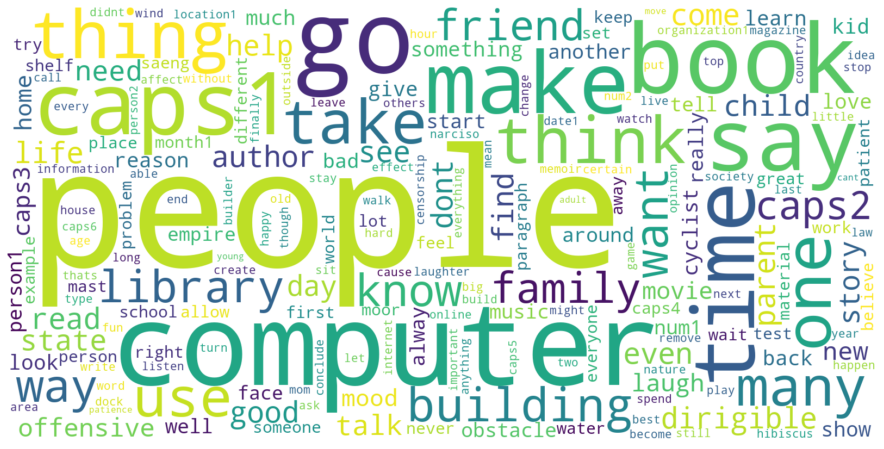

In [ ]:
from wordcloud import WordCloud
word_cloud = WordCloud(
                       width=1600,
                       height=800,
                       background_color="white",collocations=False
            ).generate(" ".join(df_train['text']))

plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

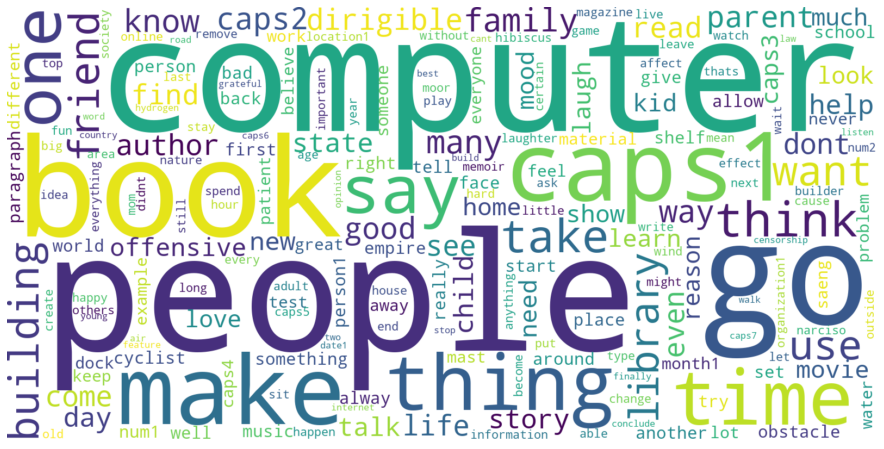

In [ ]:
word_cloud = WordCloud(
                       width=1600,
                       height=800,
                       margin=0,
                       background_color="white",collocations=False
            ).generate(" ".join(df_test['text']))

plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

####Vectorización
Por último convertiremos el texto ya procesado y tokenizado en vector. Para ello utilizaremos el método [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) de scikit-learn. El cual construye una transformación de tokens a vectores a partir del vocabulario de nuestros datos.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Creo una lista con todos los textos de entrenamiento
text_train    = [''.join(x) for x in df_train["text"]] # train texts
# Creo una lista con todos los textos de validación
text_test    = [''.join(x) for x in df_test["text"]] # val texts

# Unifico ambas para crear una lista con todos los textos
# para entrenar el vectorizador
texts = text_train + text_test

In [ ]:
# Vectorizador
vectorizer = CountVectorizer(max_features=5000) 
vectorizer = vectorizer.fit(texts) #utilizo todos los textos
print("Vocabulary size:{}".format(len(vectorizer.vocabulary_)))

Vocabulary size:5000


In [ ]:
X_train = vectorizer.transform(df_train['text'])
y_train = df_train['score']

X_test = vectorizer.transform(df_test['text'])
y_test = df_test['predicted_score']

##Modelos 

Se entrenarán varios modelos de clasificadores desde los más simples: Naive Bayes y Kmeans hasta modelos más complejos de *DeepLearning* utilizando una red neuronal secuencial con capas LSTM. La documentación del dataset indica que debemos utilizar la métrica "*quadratic cohen kappa score*" para comparar el desempeño de los modelos.

In [ ]:
# Silencio las advertencias
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#imports
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import time

import tensorflow as tf

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, cohen_kappa_score

#Creo un "scorer" utilizando la métrica que indica el dataset: COHEN KAPPA SCORE
kappa = make_scorer(cohen_kappa_score, weights='quadratic')

El primer modelo a entrenar es una variante de Naive Bayes, muy utilizada en
clasificación de texto porque produce resultados tan buenos como otros modelos
más sofisticados. El nombre de ["Naive Bayes Multinomial"](https://ccc.inaoep.mx/~esucar/Clases-mgp/Proyectos/MGP_RepProy_Abr_29.pdf) se debe a que cada
$p(fi|c)$ es una distribución multinomial (donde $p(fi|c)$ es la probabilidad
condicional de que se observe un patrón "fi" cuando el evento es de la clase "c"), en vez de otro tipo de distribuciones. Este clasificador es recomendable para datos que pueden ser transformados en contadores, tales como contadores de palabras en un texto.

In [ ]:
classifier1 = MultinomialNB()

classifier1.fit(X_train, df_train["score"].astype(int))
training_score1 = cross_val_score(classifier1, X_train, df_train["score"].astype(int), cv=5, scoring=kappa )
print("Classifiers: ", classifier1.__class__.__name__, "Has a training score of", round(training_score1.mean()* 100,1), "% accuracy score")

y_pred = classifier1.predict(X_test)
test_score1 = cohen_kappa_score(df_test["predicted_score"],y_pred,weights='quadratic')
print("Classifiers: ", classifier1.__class__.__name__, "Has a validation score of", round(test_score1.mean()* 100,1), "% accuracy score")

#5.1% #56.3%

Classifiers:  MultinomialNB Has a training score of 93.7 % accuracy score
Classifiers:  MultinomialNB Has a validation score of 22.6 % accuracy score


El segundo modelo a utilizar es "K vecinos más cercanos", el cual ha sido utilizado tanto en clasificación como en "clustering". La desventaja de este simple clasificador recide en un coste de memoria ya que debemos almacenar una potencial gran cantidad de datos, pero a su vez computacional ya que debemos comparar el dato deseado con los datos utilizados en el entrenamiento. Se basa en contar los K vecinos cercanos, y buscar la clase a la que la mayor cantidad de vecinos pertenece. Dicha clase le será asignada al dato que deseamos clasificar.

In [ ]:
classifier2 = KNeighborsClassifier(n_neighbors=5)

classifier2.fit(X_train, df_train["score"].astype(int))
training_score2 = cross_val_score(classifier2, X_train, df_train["score"].astype(int), cv=5, scoring=kappa )
print("Classifiers: ", classifier2.__class__.__name__, "Has a training score of", round(training_score2.mean()* 100,1), "% accuracy score")

y_pred = classifier2.predict(X_test)
test_score2 = cohen_kappa_score(df_test["predicted_score"],y_pred,weights='quadratic')
print("Classifiers: ", classifier2.__class__.__name__, "Has a validation score of", round(test_score2.mean()* 100,1), "% accuracy score")

#87.6% #27.2%

Classifiers:  KNeighborsClassifier Has a training score of 65.9 % accuracy score
Classifiers:  KNeighborsClassifier Has a validation score of 33.5 % accuracy score


El próximo modelo que utilizaremos es la "Regresión Logística" que a pesar de su nombre es un clasificador. Su nombre se debe a que se realiza una regresión respecto a la probabilidad de que un patrón pertenezca a una determinada clase. Se elige una clase más problabe dada una observación, donde la probabilidad no se calcula en base a parámetros estádisticos sino con una función de regresión.


In [ ]:
classifier3 = LogisticRegression(max_iter=100, n_jobs=-1)

classifier3.fit(X_train, df_train["score"].astype(int))
training_score3 = cross_val_score(classifier3, X_train, df_train["score"].astype(int), cv=2, scoring=kappa)
print("Classifiers: ", classifier3.__class__.__name__, "Has a training score of", round(training_score3.mean(), 2) * 100, "% accuracy score")

y_pred = classifier3.predict(X_test)
test_score3 = cohen_kappa_score(df_test["predicted_score"],y_pred,weights='quadratic')
print("Classifiers: ", classifier3.__class__.__name__, "Has a validation score of", round(test_score3.mean() * 100, 2), "% accuracy score")

#76% #29%

Classifiers:  LogisticRegression Has a training score of 86.0 % accuracy score
Classifiers:  LogisticRegression Has a validation score of 23.53 % accuracy score


El cuarto modelo es "SVC" de sus siglas en ingles "Support Vector Machine". Este clasificador se basa en que los puntos etiquetados no son linealmente separables pero que son mapeables (utilizando un kernel) a un espacio donde la separación es posible. Las ventajas de este modelo es que dado un conjunto de puntos etiquetados linealmente separables, es posible encontrar un hiperplano de separación óptima y por lo tanto menos sensible al ruido y overfitting.

In [ ]:
classifier4 = SVC()

classifier4.fit(X_train, df_train["score"].astype(int))
training_score4 = cross_val_score(classifier4, X_train, df_train["score"].astype(int), cv=5, scoring=kappa )
print("Classifiers: ", classifier4.__class__.__name__, "Has a training score of", round(training_score4.mean(), 2) * 100, "% accuracy score")


y_pred = classifier4.predict(X_test)
test_score4 = cohen_kappa_score(df_test["predicted_score"],y_pred,weights='quadratic')
print("Classifiers: ", classifier4.__class__.__name__, "Has a validation score of", round(test_score4.mean()* 100,1), "% accuracy score")

# #28%

Classifiers:  SVC Has a training score of 87.0 % accuracy score
Classifiers:  SVC Has a validation score of 26.2 % accuracy score


A continuación se utilizan un clasificador "Random Forest" y XGBClasifier. La diferencia principal de ambos radica en como son construidos los árboles y como se combinan los resultados:

 How trees are built: random forests builds each tree independently while 

*   Construcción de los árboles: random forest crea cada árbol independientemente, mientras que XGBoosting crea un árbol a la vez. Este ensamble funciona de manera progresiva por etapas utilizando el descenso de gradiente.
*   Combinar resultados: "Random Forest" combina los resultados al final del proceso (por promediación, etc.) mientras que "XGB" combina los resultados a lo largo del proceso.

In [ ]:
# The full pipeline as a step in another pipeline with an estimator as the final step.
pipe = Pipeline(steps = [("fs", SelectKBest()),
                         ("clf", XGBClassifier())])

seed = 42
num_folds = 5
# Creating a dictionary with the hyperparameters.
search_space = [
                {"clf": [RandomForestClassifier()],
                 "clf__n_estimators": [800],
                 "clf__criterion": ["gini", "entropy"],
                 "clf__max_leaf_nodes": [300],
                 "clf__random_state": [seed],
                 "clf__oob_score": [True],
                 "fs__score_func": [chi2],
                 "fs__k": [10]},
                {"clf": [XGBClassifier()],
                 "clf__n_estimators": [300],
                 "clf__max_depth": [4],
                 "clf__learning_rate": [0.1],
                 "clf__random_state": [seed],
                 "clf__subsample": [1],
                 "clf__colsample_bytree": [1],
                 "clf__tree_method": ["gpu_hist"],  # For using the GPU.
                 "fs__score_func":[chi2],
                 "fs__k":[13]}
]

# Defining StratifiedKFold object.
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)

# Creating the GridSearchCV object.
grid = GridSearchCV(estimator=pipe, 
                    param_grid=search_space,
                    cv=kfold,
                    scoring=kappa,
                    return_train_score=True,
                    n_jobs=-1,
                    refit="AUC")

# Getting the time start.
tmp = time.time()

# Fitting the GridSearchCV object.
best_model = grid.fit(X_train, y_train.astype(int))

# Printing the time spent.
#print("CPU Training Time: %s seconds" % (str(time.time() - tmp)))  # 311.7510848045349 seconds
print("GPU Training Time: %s seconds" % (str(time.time() - tmp)))  # 301.1867105960846 seconds
print()


print("Classifiers: ", best_model.best_params_['clf'].__class__.__name__, "Has a training score of", round(best_model.best_score_, 2) * 100, "% accuracy score")

y_pred = best_model.predict(X_test)
test_score5 = cohen_kappa_score(df_test["predicted_score"],y_pred,weights='quadratic')
print("Classifiers: ", best_model.best_params_['clf'].__class__.__name__, "Has a validation score of", round(test_score5.mean(), 2) * 100, "% accuracy score")

GPU Training Time: 155.19017910957336 seconds

Classifiers:  RandomForestClassifier Has a training score of 90.0 % accuracy score
Classifiers:  RandomForestClassifier Has a validation score of 24.0 % accuracy score


Por último se presenta un modelo de redes neuronales que posee dos capas LSTM (Long Short Therm Memory). Para utilizar este modelo es necesario vectorizar nuevamente nuestros datos, debido a que el método utilizado anteriormente requería disminuir la dimensionalidad de los vectores debido a la gran cantidad de memoría que requería una red capaz de procesarlo.

Se estudió utilizar este método de vectorización pero los resultados obtenidos en los modelos anteriores poseían un peor desempeño.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(texts)
X_train = tokenizer.texts_to_sequences(df_train['text'])
X_test = tokenizer.texts_to_sequences(df_test['text'])

X_train = pad_sequences(X_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test = pad_sequences(X_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

tf.keras.backend.clear_session()

#Modelo Secuencial
model = Sequential()
model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1,max_length], return_sequences=True))
model.add(LSTM(64, recurrent_dropout=0.4))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 300)            601200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 694,705
Trainable params: 694,705
Non-trainable params: 0
_________________________________________________________________


Utilizaremos KFold para obtener un resultado más robusto con un número de $folds = 5$

In [ ]:
from keras.optimizers import RMSprop
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])

X_train1 = X_train[...,None]
X_train1 = np.reshape(X_train1,(X_train1.shape[0],1,X_train1.shape[1]))

X_test1 = X_test[...,None]
X_test1 = np.reshape(X_test1,(X_test1.shape[0],1,X_test1.shape[1]))

results = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train, test in kfold.split(X_train1, y_train.astype(int)):
  print("NEW KFOLD")
  trainX, testX = X_train1[train], X_train1[test]
  trainY, testY = y_train.iloc[train], y_train.iloc[test]


  model.fit(X_train1, y_train.astype(int), batch_size=64, epochs=50, verbose = 0)
  y_pred = model.predict(X_test1)

  # Round y_pred to the nearest integer.
  y_pred = np.around(y_pred)

  # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
  result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
  print("Kappa Score: {}".format(result))
  results.append(result)

print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=4))

NEW KFOLD
Kappa Score: 0.3459300272084297
NEW KFOLD
Kappa Score: 0.37365563634322796
NEW KFOLD
Kappa Score: 0.37549322948634034
NEW KFOLD
Kappa Score: 0.3736337313737643
NEW KFOLD
Kappa Score: 0.29123022716644176
Average Kappa score after a 5-fold cross validation:  0.352


Nota: No se ha implementado la métrica de "Cohen Kappa Score" en keras, por lo que no puede ser utilizada en el entrenamiento.

##Resultados

Luego de entrenar los modelos se obtuvieron los siguientes resultados:

In [ ]:
Resultados = pd.DataFrame({"MultinomialNB": [training_score1.mean(), test_score1.mean()],
                          "KNeighbors": [training_score2.mean(), test_score2.mean()],
                          "LogisticRegression": [training_score3.mean(), test_score3.mean()],
                          "SVC": [training_score4.mean(), test_score4.mean()],
                          "RF y XGB": [best_model.best_score_, test_score5.mean()],
                          "LSTM": [np.nan, np.around(np.array(results).mean(),decimals=4)]},
                          index=["train_score", "test_score"])
Resultados

,MultinomialNB,KNeighbors,LogisticRegression,SVC,RF y XGB,LSTM
train_score,0.937229,0.658595,0.860176,0.872664,0.897760,NaN
test_score,0.226394,0.335223,0.235272,0.262344,0.238629,0.352


Al comparar el desempeño de todos los modelos podemos observar que en la mayoría de los casos existe una amplia diferencia en el desempeño entre la validación y el entrenamiento. El mejor desempeño obtenido, en validación es de un 35.2% utilizando la red LSTM; mientras que el peor fue obtenido por el "Multinomial NB", pero debido a su simpliceza y a la pequeña diferencia en rendimiento frente a modelos mas complejos como "SVC" (apenas un 3.6% o 0.036) es muy utilizado en la actualidad. Es por esto que siempre se recomienda contrastar nuestros modelos con datos que no hayan sido utilizados en el entrenamiento, aunque puede deberse a un set de validación de mala calidad.